# 1.Import

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import heatmap
import numpy as np

# 2.Load dataset

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv("train.csv")
y = df.pop("Transported")
df.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


# 3.Split cabin information by deck, num, side

In [3]:
def CabinSplit(df):
    df["Deck"] = df["Cabin"].str.split("/").str[0]
    df["Num"] = list(map(float, df["Cabin"].str.split("/").str[1]))
    df["Side"] = df["Cabin"].str.split("/").str[2]
    df = df.drop(["Cabin", "PassengerId", "Destination", "Name"], axis=1)
    return df
df = CabinSplit(df)
df.head(5)

,HomePlanet,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Num,Side
0,Europa,False,39.0,False,0.0,0.0,0.0,0.0,0.0,B,0.0,P
1,Earth,False,24.0,False,109.0,9.0,25.0,549.0,44.0,F,0.0,S
2,Europa,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,0.0,S
3,Europa,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,0.0,S
4,Earth,False,16.0,False,303.0,70.0,151.0,565.0,2.0,F,1.0,S


# 4.Missing Values

<AxesSubplot:>

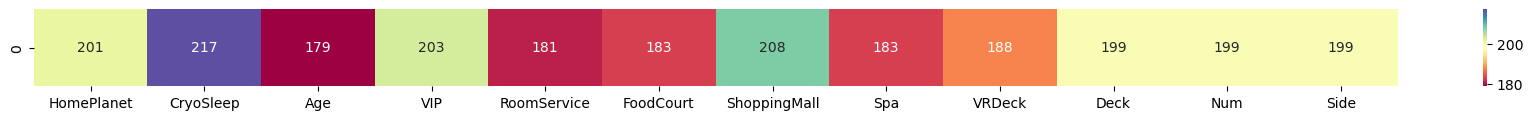

In [4]:
plt.figure(figsize=(22,1))
heatmap(pd.DataFrame(np.asarray(df.isna().sum()).reshape(1, df.shape[1]), columns=list(df.columns)),cmap='Spectral', annot=True, fmt=".0f")

In [5]:
def FillNaN(df):
    mf = ["HomePlanet", "CryoSleep", "VIP", "Side", "Deck"]
    mean = ["Age"]
    zero = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Num"]
    df[mf] = df[mf].fillna(df.mode().iloc[0])
    df[mean] = df[mean].fillna(df[mean].mean())
    df[zero] = df[zero].fillna(0)
    return df
df = FillNaN(df)
df.head(5)

,HomePlanet,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Num,Side
0,Europa,False,39.0,False,0.0,0.0,0.0,0.0,0.0,B,0.0,P
1,Earth,False,24.0,False,109.0,9.0,25.0,549.0,44.0,F,0.0,S
2,Europa,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,0.0,S
3,Europa,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,0.0,S
4,Earth,False,16.0,False,303.0,70.0,151.0,565.0,2.0,F,1.0,S


# 5.Feature Engineering

In [6]:
def FeatureCreation(df):
    df["MoneySpent"] = df["RoomService"] + df["FoodCourt"] + df["ShoppingMall"] + df["Spa"] + df["VRDeck"]
    df.insert(loc = 3, column="AgeCategories",value=0)
    df.loc[df["Age"] <= 14, "AgeCategories"] = 1
    df.loc[(df["Age"] > 14) & (df["Age"] <= 24), "AgeCategories"] = 2
    df.loc[(df["Age"] > 24) & (df["Age"] <= 64), "AgeCategories"] = 3
    df.loc[(df["Age"] > 64), "AgeCategories"] = 4
    return df
df = FeatureCreation(df)

# 6.Encode values with get_dummies and LabelEncoder

In [7]:
def Encode(df):
    df = pd.concat([df, pd.get_dummies(df[["Deck", "Side", "HomePlanet"]])], axis=1)
    df = pd.concat([df, pd.get_dummies(df["AgeCategories"])], axis=1)
    df[["CryoSleep", "VIP"]] = df[["CryoSleep", "VIP"]].apply(LabelEncoder().fit_transform)
    df = df.drop(["Deck", "Side", "HomePlanet", "AgeCategories"], axis=1)
    return df
df = Encode(df)
y = LabelEncoder().fit_transform(y)
df.head(5)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,MoneySpent,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,1,2,3,4
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,0.0,736.0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0.0,10383.0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0.0,5176.0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1.0,1091.0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0


# 7.Apply StandardScaler

In [8]:
def Norm(df):
    for col in df:
        if df[col].dtypes == "float64":
            df[col] = StandardScaler().fit_transform(np.array(df[col]).reshape(-1, 1))
    return df
df = Norm(df)
df.head(5)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,MoneySpent,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,1,2,3,4
0,0,0.709437,0,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,-1.141624,-0.514066,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
1,0,-0.336717,0,-0.168073,-0.275387,-0.241771,0.217158,-0.224205,-1.141624,-0.251479,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0
2,0,2.034566,1,-0.268001,1.959998,-0.283579,5.695623,-0.219796,-1.141624,3.190333,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
3,0,0.290975,0,-0.333105,0.523010,0.336851,2.687176,-0.092818,-1.141624,1.332604,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
4,0,-0.894666,0,0.125652,-0.237159,-0.031059,0.231374,-0.261240,-1.139678,-0.124824,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0


# 8.Create datasets

In [9]:
x_train, x_validation, y_train, y_validation = train_test_split(df, y, test_size=0.2, shuffle=True, random_state=5)

In [10]:
class Dataset(Dataset):
    def __init__(self, x, y):
        self.df = np.array(x)
        self.df_labels = np.array(y)
        self.dataset = torch.tensor(self.df)
        self.labels = torch.tensor(self.df_labels)
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, index):
        return self.dataset[index], self.labels[index]
batch_size = 64
train_dataloader = DataLoader(Dataset(x_train, y_train), batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(Dataset(x_validation, y_validation), batch_size=batch_size, shuffle=True)

# 9.Modeling

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975993/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_size, 1),
        )
        

    def forward(self, x):
        return self.model(x)

input_size = x_train.shape[1]
hidden_size = int(input_size * 1.5)
model = NeuralNetwork(input_size, hidden_size).to(device)
print(model)

NeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=27, out_features=40, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=40, out_features=1, bias=True)
  )
)


# 10.Model training

In [13]:
epochs = 200
lr = 0.003
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [14]:
def progress_bar(progress, total, lenght):
    percent = lenght * (progress / total)
    bar = "❚" * int(percent) + " " * (lenght - int(percent))
    return bar

In [15]:
train_plot = []
val_plot = []
train_accuracy_plot = []
val_accuracy_plot = []
for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    train_correct = 0
    val_correct = 0
    for x, y in train_dataloader:
        optimizer.zero_grad()
        x, y = x.to(device).float(), y.to(device).float().unsqueeze(1)
        output = model(x)
        loss = criterion(output, y)
        train_loss += criterion(output, y).item()
        train_correct += (y == torch.round(torch.sigmoid(model(x)))).float().sum()
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        for x_val, y_val in val_dataloader:
            x_val, y_val = x_val.to(device).float(), y_val.to(device).float().unsqueeze(1)
            pred = model(x_val)
            loss = criterion(pred, y_val)
            val_loss += criterion(pred, y_val).item()
            val_correct += (y_val == torch.round(torch.sigmoid(model(x_val)))).float().sum()
    train_plot.append((train_loss/len(train_dataloader)))
    val_plot.append((val_loss/len(val_dataloader)))
    train_accuracy_plot.append((train_correct / len(y_train)).item())
    val_accuracy_plot.append((val_correct / len(y_validation)).item())
    print(fr"|{progress_bar(epoch + 1, epochs, 50)}| {epoch + 1} / {epochs}, train_loss = {(train_loss/len(train_dataloader)):.5f}, val_loss = {(val_loss/len(val_dataloader)):.5f}, train_accuracy = {(train_correct / len(y_train)):.5f}, val_accuracy = {(val_correct / len(y_validation)):.5f}", end="\r")

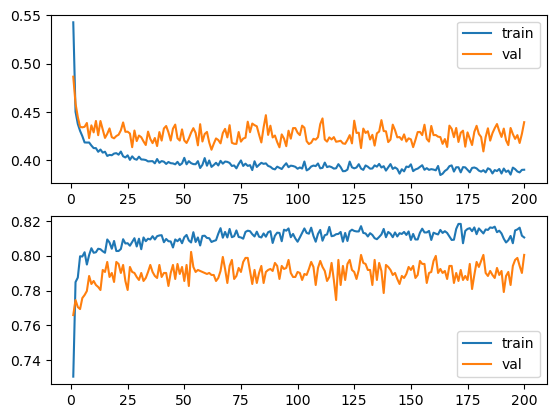

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot([i for i in range(1, epochs + 1)], train_plot, label="train")
ax1.plot([i for i in range(1, epochs + 1)], val_plot, label="val")
ax1.legend()
ax2.plot([i for i in range(1, epochs + 1)], train_accuracy_plot, label="train")
ax2.plot([i for i in range(1, epochs + 1)], val_accuracy_plot, label="val")
ax2.legend()
plt.show()

# 11.Error analysis

In [17]:
val = torch.tensor(np.array(x_validation)).float().to(device)
val_output = torch.round(torch.sigmoid(model(val)))
val_output = val_output.reshape(-1).type(torch.bool).cpu().numpy()
error_analysis_df = pd.DataFrame({"Prediction" : val_output, "TrueValue" : y_validation.astype(bool)})
TrueTrue = len(error_analysis_df.loc[(error_analysis_df["TrueValue"] == True) & (error_analysis_df["Prediction"] == True)])
FalseTrue = len(error_analysis_df.loc[(error_analysis_df["TrueValue"] == False) & (error_analysis_df["Prediction"] == True)])
TrueFalse = len(error_analysis_df.loc[(error_analysis_df["TrueValue"] == False) & (error_analysis_df["Prediction"] == False)])
FalseFalse = len(error_analysis_df.loc[(error_analysis_df["TrueValue"] == True) & (error_analysis_df["Prediction"] == False)])

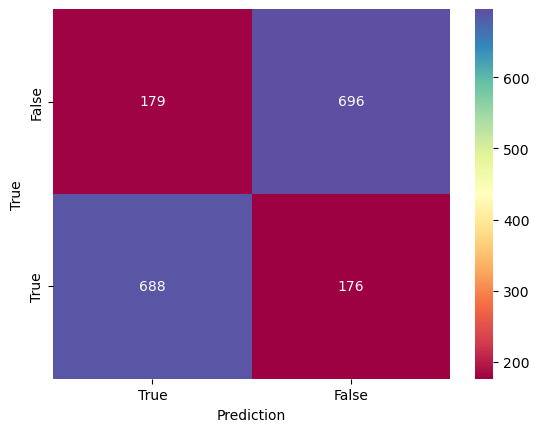

In [18]:
plt.figure()
heatmap(pd.DataFrame({"True" : [FalseTrue, TrueTrue], "False" : [TrueFalse, FalseFalse]}, index=["False", "True"]),cmap='Spectral', annot=True, fmt=".0f")
plt.xlabel("Prediction")
plt.ylabel("True")
plt.show()

In [20]:
torch.save(model.state_dict(), 'model_weights.pth')

# 12.Submission

In [19]:
test_df = pd.read_csv("test.csv")
def Preprocessing(data):
    data = CabinSplit(data)
    data = FillNaN(data)
    data = FeatureCreation(data)
    data = Encode(data)
    data = Norm(data)
    return data
test_data = Preprocessing(test_df)
test_data.head(5)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,MoneySpent,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,1,2,3,4
0,1,-0.118222,0,-0.357339,-0.283840,-0.312173,-0.267841,-0.246712,-1.146527,-0.503425,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0
1,0,-0.688601,0,-0.357339,-0.277879,-0.312173,2.287504,-0.246712,-1.144593,0.502231,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0
2,1,0.166968,0,-0.357339,-0.283840,-0.312173,-0.267841,-0.246712,-1.152328,-0.503425,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0
3,0,0.666051,0,-0.357339,4.121518,-0.312173,-0.104002,0.226648,-1.150395,2.130740,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0
4,0,-0.617304,0,-0.340723,-0.283840,0.832122,-0.267841,-0.246712,-1.142660,-0.274383,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0


In [21]:
model.load_state_dict(torch.load('model_weights.pth'))
data = torch.tensor(np.array(test_data)).float().to(device)
pred = torch.round(torch.sigmoid(model(data)))
pred = pred.reshape(-1).type(torch.bool).cpu().numpy()
submission = pd.DataFrame({"PassengerId" : test_df["PassengerId"], "Transported" : pred})
submission.to_csv("submission.csv", index=False)